# Análise do Customer Experience da Pichau informática

Nesse notebook nós vamos indentificar as proncipais falhas no CX da pichau. Isso será feito a partir das avaliações
feitas pelos clientes nos sites https://www.reclameaqui.com.br/ e https://www.ebit.com.br/

### Configurando o notebook e instalando as dependências

In [74]:
# !pip install selenium
# !apt-get update
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin

# Importando as bibliotecas
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from selenium import webdriver
import seaborn as sns
import pandas as pd
import numpy as np
import random
import time
import os

driver_path = os.getcwd().replace("notebooks", "drivers/chromedriver")

# Configurações do Selenium
chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome = webdriver.Chrome(driver_path, options=chrome_options)

## Coletando as avaliações do Ebit


In [3]:
ebit_pichau_link = "https://www.ebit.com.br/pichau-informatica"
chrome.get(ebit_pichau_link)

# Adicionando um delay para carregar a página
time.sleep(2)

# Filtrando os comentários positivos
positive_btn_xpath = "/html/body/div/div/div[3]/div/div[1]/ul/li[2]"
chrome.find_element_by_xpath(positive_btn_xpath).click()

time.sleep(2)

positive_commentary_element_list = chrome.find_elements_by_class_name("user-commentary")
positive_review_text_list = [element.text for element in positive_commentary_element_list]

# Filtrando os comentários negativos
negative_btn_xpath = "/html/body/div/div/div[3]/div/div[1]/ul/li[3]"
chrome.find_element_by_xpath(negative_btn_xpath).click()

time.sleep(2)

negative_commentary_element_list = chrome.find_elements_by_class_name("user-commentary")
negative_review_text_list = [element.text for element in negative_commentary_element_list]

# Fechando o navegador
chrome.quit()

# Criando uma tabela com os cometários
ebit_review_df = pd.DataFrame(
    {
        "Positivos": positive_review_text_list,
        "Negativos": negative_review_text_list
    }
)

# Salvando os dados
ebit_review_df.to_csv("../data/ebit-reviews.csv", index=False)

ebit_review_df.head()

,Positivos,Negativos
0,"""Loja muito confiável, não tenho do que reclam...","""Não consegui pagar com o meu cartão de crédit..."
1,"""Top de MAIS!""","""Frete foi um absurdo, sendo que era para o me..."
2,"""Muito bom como sempre""","""Ao realizar o pagamento por PIX, o código tan..."
3,"""nada a reclamar. tudo ok""","""Preços muito salgados."""
4,"""ÓTIMA LOJA, COMPREI MEU PC E OUTRAS PEÇAS NEL...","""Tem produtos d promoção q não aparecem na pes..."


### Coletando as avaliações do ReclameAqui
a coleta dos dados do ReclameAqui foi feita a partir desse repositório do GitHub https://github.com/gutessitore/ReclameAquiScrapper

In [4]:
# Lendo os dados
reclame_aqui_review_df = pd.read_csv("../data/pichau-reviews.csv")

# Separando as informações existentes
reclame_aqui_review_df[["review", "date", "city", "?"]] = reclame_aqui_review_df.review.str.split("|", expand=True)
reclame_aqui_review_df.drop("?", axis=1, inplace=True)
reclame_aqui_review_df[["review", "status"]] = reclame_aqui_review_df.review.str.rsplit("\n", 1, expand=True)

reclame_aqui_review_df.head()

,review,link,date,city,status
0,Demora no envio\nExecutei uma compra de uma ca...,https://www.reclameaqui.com.br/pichau-informat...,Há 34 minutos,Taió,Não respondida
1,Placa de video fazendo um barulho estranho e d...,https://www.reclameaqui.com.br/pichau-informat...,Há 1 hora,Jaú,Não respondida
2,Aguardando Coleta da Transportadora HÁ DIAS!\n...,https://www.reclameaqui.com.br/pichau-informat...,Há 11 horas,Cascavel,Não respondida
3,RMA com atraso\nEntreguei um teclado para RMA ...,https://www.reclameaqui.com.br/pichau-informat...,Há 13 horas,Joinville,Não respondida
4,Paguei pelo produto e não enviam\nComprei 3 pl...,https://www.reclameaqui.com.br/pichau-informat...,Há 18 horas,Bauru,Não respondida


## Análise de palavras das avaliaçoes dos sites

In [78]:
def rgb_float_to_int(rgb):
    return tuple(int(255 * c) for c in rgb)

WORDCLOUD_DOWN_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Reds', n_colors=9)[2:]]
WORDCLOUD_UP_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Blues', n_colors=9)[2:]]

def get_down_color(*args, **kwargs):
    return random.choice(WORDCLOUD_DOWN_PALETTE)

def get_up_color(*args, **kwargs):
    return random.choice(WORDCLOUD_UP_PALETTE)

def plot_wordcloud(words, words_to_remove, title, style):
    if style == 'up':
        color_function = get_up_color
        image = Image.open('../images/white-thumbs-up.png')

    elif style == 'down':
        color_function = get_down_color
        image = ImageOps.flip(Image.open('../images/white-thumbs-up.png'))

    mask = np.array(image)[:, :, 3]
    mask_icon = mask == 0
    mask_bg = mask > 0
    mask[mask_icon] = 255
    mask[mask_bg] = 0

    stopwords = set(STOPWORDS)  # Adicionando um filtro de palavras
    stopwords.update(words_to_remove)

    wordcloud = WordCloud(background_color='white', mask=mask, stopwords=stopwords)
    wordcloud.generate(words)
    wordcloud.recolor(color_func=color_function)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title + "\n", fontsize=20)
    plt.axis('off')
    plt.gcf().set_size_inches(16, 10)

## Ebit

In [30]:
import pandas as pd
ebit_informaçao_site=pd.read_csv(r'../data/informaçoes_site.csv', sep=',')
ebit_informaçao_site=ebit_informaçao_site.replace({'Comprariam_novamente':{u'ã':'a'}}, regex=True)
ebit_informaçao_site=ebit_informaçao_site.replace({'Entrega_no_prazo':{u'ã':'a'}}, regex=True)
ebit_informaçao_site=ebit_informaçao_site.replace({'Indicaria_a_amigos':{u'ã':'a'}}, regex=True)
display(ebit_informaçao_site)


,Comprariam_novamente,Entrega_no_prazo,Indicaria_a_amigos
0,Compraria,Entregou,Indicaria
1,Compraria,Entregou,Indicaria
2,Compraria,Entregou,Indicaria
3,Compraria,Entregou,Indicaria
4,Compraria,Entregou,Indicaria
...,...,...,...
94,Nao Compraria,Nao Entregou,Nao indicaria
95,Nao Compraria,Nao Entregou,Nao indicaria
96,Nao Compraria,Nao Entregou,Nao indicaria
97,Nao Compraria,Nao Entregou,Nao indicaria


<AxesSubplot:ylabel='Comprariam_novamente'>

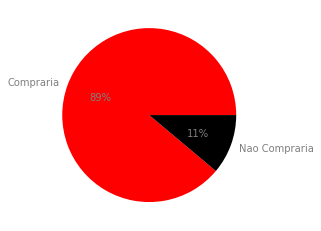

In [119]:
plt.axis('off')
ebit_informaçao_site.groupby(['Comprariam_novamente']).Comprariam_novamente.count()[-5:].plot(kind='pie', autopct='%1.0f%%', colormap='flag', textprops={'color':"grey"})

<AxesSubplot:ylabel='Entrega_no_prazo'>

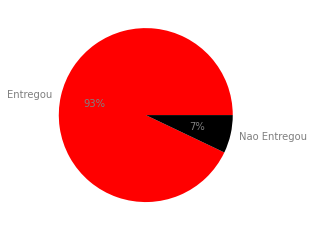

In [118]:
plt.axis('off')
ebit_informaçao_site.groupby(['Entrega_no_prazo']).Entrega_no_prazo.count()[-5:].plot(kind='pie', autopct='%1.0f%%', colormap='flag', textprops={'color':"grey"})

<AxesSubplot:ylabel='Indicaria_a_amigos'>

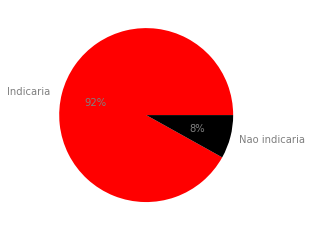

In [117]:
plt.axis('off')
ebit_informaçao_site.groupby(['Indicaria_a_amigos']).Indicaria_a_amigos.count()[-5:].plot(kind='pie', autopct='%1.0f%%',colormap='flag', textprops={'color':"grey"})

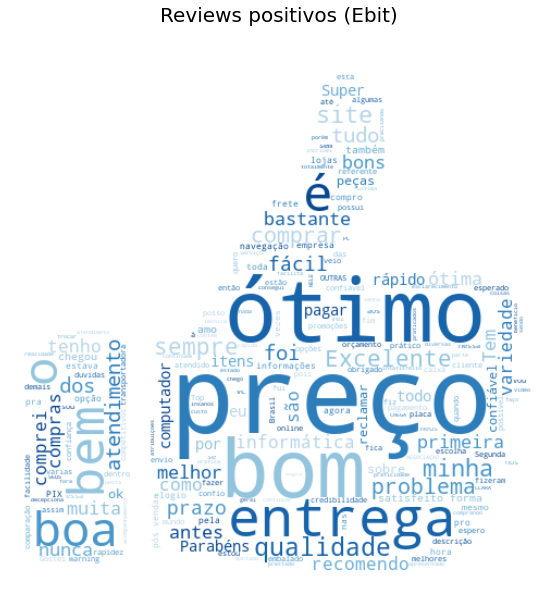

In [80]:

compliment_text = " ".join(ebit_review_df.Positivos)  # Juntando os reviews em um unico texto
words_to_remove = ["da", "meu", "em", "você", "de", "ao", "os", "na", "loja",
         "produto", "produtos", "pichau", "já", "tive", "comum", "ainda",
         "que", "não", "para", "um", "mas", "mais", "uma", "compra", "muito", 
         "e", "é"]

plot_wordcloud(compliment_text, words_to_remove, "Reviews positivos (Ebit)", "up")


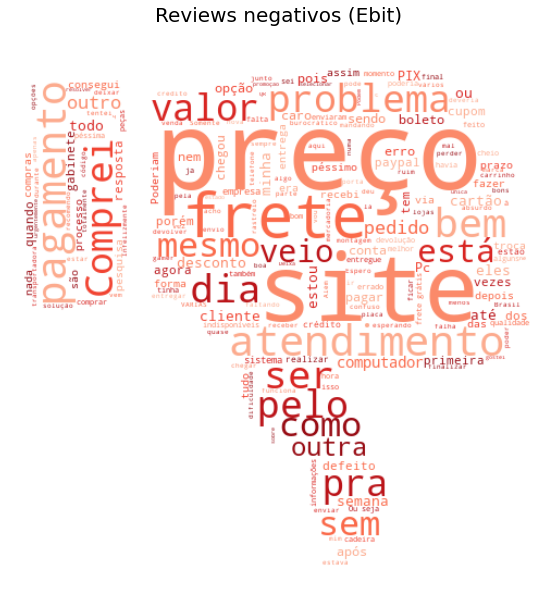

In [81]:
complaint_text = " ".join(ebit_review_df.Negativos)  # Juntando os reviews em um unico texto

words_to_remove = ["da", "meu", "em", "você", "de", "ao", "os", "na", "loja",
     "produto", "produtos", "pichau", "já", "tive", "comum", "ainda",
     "que", "não", "para", "um", "mas", "mais", "uma", "compra", "por",
     "foi", "só", "se", "ele", "ter", "essa", "eu", "muito", "e", "o",
     "é"]

plot_wordcloud(complaint_text, words_to_remove, "Reviews negativos (Ebit)", "down")

## Reclame Aqui

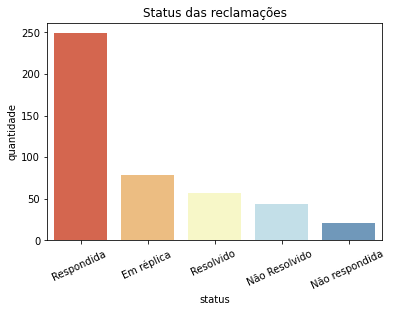

In [108]:
status_count = pd.DataFrame(reclame_aqui_review_df.status.value_counts())
status_count.reset_index(inplace=True)
status_count.columns = ["status", "quantidade"]

plt.xticks(rotation=25)
plt.title("Status das reclamações")
sns.barplot(x="status", y="quantidade", data=status_count, palette="RdYlB");

Geralmente eles respondem as reclamações em aberto, porém a quantidade de reclamações em réplica junto com os casos
não resolvidos representam uma quantidade significativa dos casos. Indicando um serviço ao consumidor demorado e incompleto.

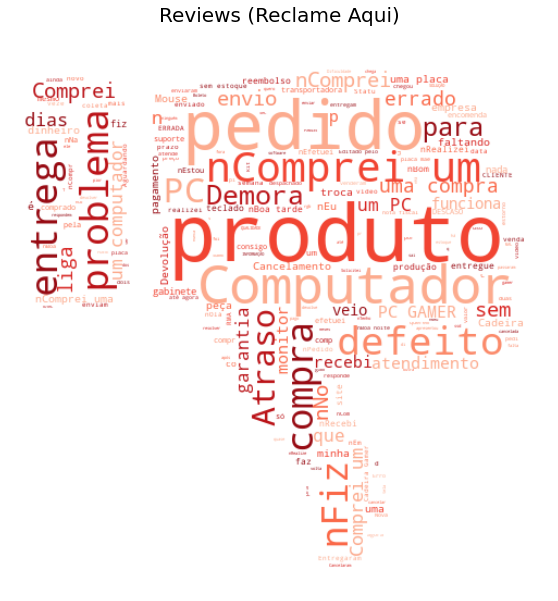

In [109]:
rl = reclame_aqui_review_df.review.to_string()
words_to_remove = ["da", "meu", "em", "você", "de", "ao", "os", "na", "loja", "não", "e",
                   "Pichau", "o", "dia", "NAO"]
plot_wordcloud(rl, words_to_remove, "Reviews (Reclame Aqui)", "down")

In [56]:
def find_comments_with_word(lista, palavra):
    return [review for review in lista if palavra in review]


# rl = reclame_aqui_review_df.review.astype("string")
# rl.fillna(" ", inplace=True)
# find_comments_with_word(rl, "entrega")

### Comentários Reclame Aqui
Percebemos que as palavras mais comuns nos comentários do Reclame Aqui foram:
<br>
produto, pedido, problema, defeito, atraso e entrega.
<br> <br>
alguns exemplos:
- “Paguei pelo produto e não enviam”
- “Fiz um pedido na Pichau Informática e não recebi o produto”
- “Demora no envio do produto”
- “recebi o computador já apresentando problemas”
- “Computador com defeito”
- “Compra com atraso na entrega”
- “O atraso na entrega caracteriza descumprimento de oferta”
- “Pichau não está honrando com prazo entrega”
- “Atraso na coleta do pedido e descaso com o cliente”
- “Atraso na entrega. Já se passaram 10 dias do prazo”
- “Prazo de entrega não condiz com o informado”
<br> <br>
O que indica uma falta de comprometimento com a qualidade dos produtos oferecidos e com o prazo de entrega dos mesmos.
<br> <br>
Observando a própria classificação do site podemos afirmar que a entrega é um dos principais pontos de falha na
entrega de uma boa experiência de usuário.
<br><br>
<table>
    <tr>
        <th>Tipo do problema</th>
        <th>Ocorrências</th>
    </tr>
    <tr>
        <td>Componentes, peças e acessórios</td>
        <td>8356</td>
    </tr>
    <tr>
        <td>Atraso na entrega</td>
        <td>5677</td>
    </tr>
    <tr>
        <td>Problemas com o Atendimento</td>
        <td>2024</td>
    </tr>
</table>


### Comentários Ebit
Percebemos que as palavras mais comuns nos comentários do Ebit aqui foram:
<br> <br>
positivos: preço, entrega, qualidade, variedade, prazo e computador.
<br>
negativos: preço, frete, site, atendimento, valor e pagamento.
<br> <br>
alguns exemplos:
- "Envio trocado e atraso na entrega"
- "Falha no envio pelo atraso na entrega"
- "Atendimento precário e demorado"
- "Falta de promoções e descontos"
- "Falta de peças na encomenda"
- "Site pouco informativo e com informações"
- "Pós-venda precário"
- "Atendimento muito robotizado"
- "Frete caro para entregas que já são caras"
- "Métodos de pagamentos não funcionam ou dão problema no meio do processamento"
<br> <br>
Indicando uma lacuna de profissionalismo nos atendimentos, uma falta de comprometimento com a qualidade e conferência dos produtos enviados.
<br><br>
Observamos na tabela a seguir que o problema mais recorrente escrito pelos clientes são os preços altos, falta de frete grátis e promoções, e os métodos de pagamentos falhos ou precários.
<br><br>
<table>
    <tr>
        <th>Tipo do problema</th>
        <th>Ocorrências</th>
    </tr>
    <tr>
        <td>Problemas com o Atendimento</td>
        <td>18</td>
    </tr>
    <tr>
        <td>Falha na entrega ou transporte</td>
        <td>24</td>
    </tr>
    <tr>
        <td>Site e/ou informações falhas</td>
        <td>19</td>
    </tr>
    <tr>
        <td>Componentes, produtos e acessórios</td>
        <td>19</td>
    </tr>
    <tr>
        <td>Preços, pagamentos e promoções</td>
        <td>52</td>
    </tr>
</table>


# Avaliando o CX da Pichau
### Métricas
- Average Resolution Time (1 dia e 12 horas)
- Customer Satisfaction Score (fornecido pelo RL 5.07/10)
- Taxa de retenção (51.1%)

### Kabum como referência
- Average Resolution Time (2 dias e 10 horas)
- Customer Satisfaction Score (fornecido pelo RL 6.28/10)
- Taxa de retenção (69.8%)

### Carrefour como referência
- Blockchain
- QR code para cada produto
- 